## Simulação do modelo de primeira ordem com atraso (First Order Process Time Delay) do Módulo Peltier


A simulação aqui têm como objetivo entender os métodos de identificação em frequência utilizando sinais não periódicos conforme descrito no livro do Iseman (capítulo 3).

Por razões de simplicidade foi utilizado um modelo de primeira ordem com atraso do processo que deseja-se analisar, as análises descritas nesse notebook são baseadas no modelo identificado o trabalho *Two-input Two-output Laboratory-scale Temperature System Based on Peltier Modules*.

In [1]:
# from scipy import *
from numpy import *
from sympy import symbols, Matrix
import sympy as sp
from matplotlib.pyplot import *

def FOPTD(gain, t_const, t_delay, s = symbols("s")):
    "Retorna o modelo de primeira ordem com atraso"
    return gain / (1 + s*t_const) * sp.exp(-t_delay*s)

t = symbols("t", real=True, positive=True)
s = symbols("s")
omega = symbols("\omega", real=True, positive=True)

G11 = FOPTD(1.186, 99.36, 12.58)
G12 = FOPTD(0.83, 166.76, 29)
G21 = FOPTD(0.66, 124.76, 48)
G22 = FOPTD(2.36, 109, 5.86)

G = array([[G11, G12], [G21, G22]])
Matrix(G)

Matrix([
[1.186*exp(-12.58*s)/(99.36*s + 1), 0.83*exp(-29*s)/(166.76*s + 1)],
[   0.66*exp(-48*s)/(124.76*s + 1),  2.36*exp(-5.86*s)/(109*s + 1)]])

### Sinais

- Excitação da malha 1 com um sinal não periódico conhecido
- Sinal pulso com duração T variável

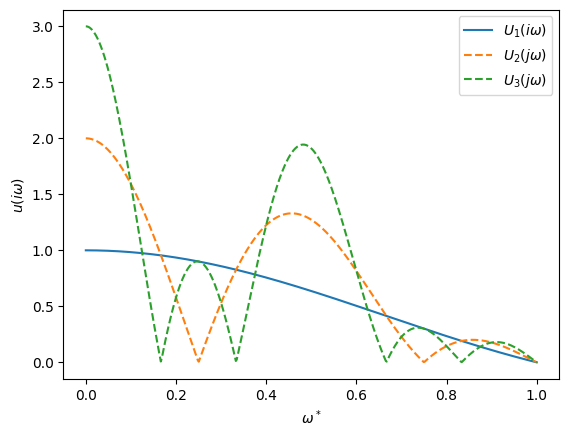

In [5]:
def pulse_signal(T):
    num = 1 - sp.exp(-T*s)
    den = s
    return num / den

def eval_signal(signal, span=(1e-10, 2*pi)):
    w = linspace(span[0], span[1], 500)
    x = signal.subs(s, sp.I * omega)
    fx = sp.lambdify(omega, x, "numpy")
    eval = fx(w)
    return w, eval

T = 1
u1 = pulse_signal(T)
u2 = u1 + pulse_signal(T)*sp.exp(-(2*T)*s)
u3 = u2 + pulse_signal(T)*sp.exp(-(4*T)*s)

w, eval1 = eval_signal(u1)
_, eval2 = eval_signal(u2)
_, eval3 = eval_signal(u3)

plot(0.5*w/pi, abs(eval1), '-', label="$U_1(i\omega)$")
plot(0.5*w/pi, abs(eval2), '--', label="$U_2(j\omega)$")
plot(0.5*w/pi, abs(eval3), '--', label="$U_3(j\omega)$")
ylabel("$u(i\omega)$"), xlabel("$\omega^*$")
legend();

### Identificação

- Aplicando um pulso retangular de corrente, com largura T na entrada do sistema

In [3]:
U1 = 1.5*pulse_signal(T = 1)
Y11 = G11 * U1
Y12 = G12 * 0

Y21 = G21 * U1

y11 = sp.inverse_laplace_transform(Y11, s, t)
y21 = sp.inverse_laplace_transform(Y21, s, t)

def eval_real(y, t0, t1):
    x = linspace(t0, t1, 500)
    fx = sp.lambdify(t, y, "numpy")
    eval = fx(x)
    return x, eval

t_, y11 = eval_real(y11, 0, 2000)
_ ,  y21 = eval_real(y21, 0, 2000)

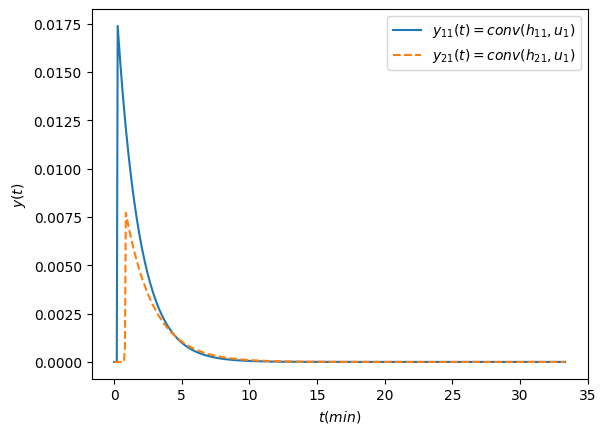

In [4]:
plot(t_/60, y11, '-' , label="$y_{11}(t)=conv(h_{11}, u_{1})$")
plot(t_/60, y21, '--', label="$y_{21}(t)=conv(h_{21}, u_{1})$")
ylabel("$y(t)$"), xlabel("$t (min)$")
legend();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


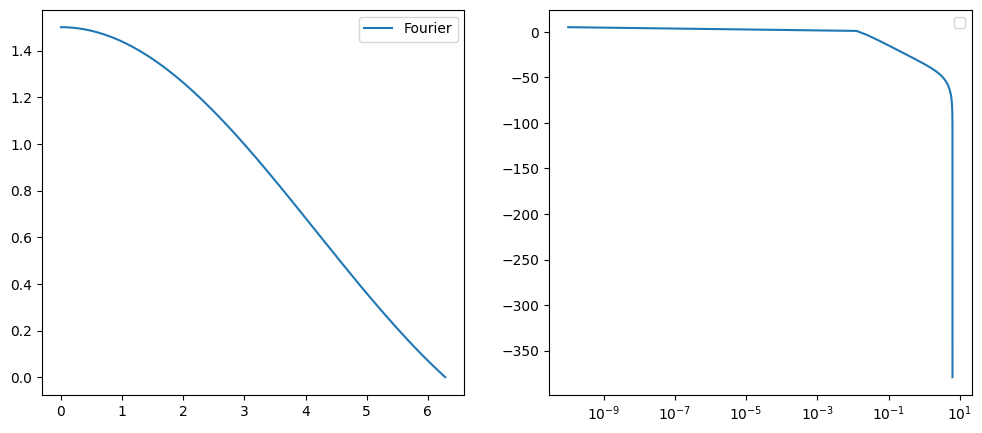

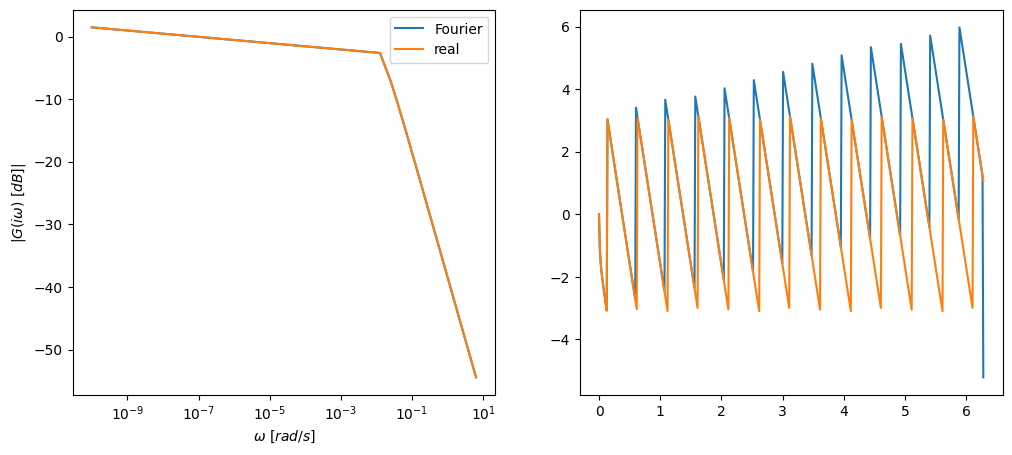

In [200]:
w, Y11_abs = eval_signal(signal=Y11)
_, U1_abs  = eval_signal(signal=U1)
_, G11_abs = eval_signal(signal=G11)

figure(figsize=(12,5))
ax = subplot(1, 2, 1)
plot(w, abs(U1_abs), label="Fourier")
legend()
ax = subplot(1, 2, 2), legend()
semilogx(w, 20*log10(abs(Y11_abs)), label="Fourier")

figure(figsize=(12,5))

ax = subplot(1, 2, 1)
semilogx(w, 20*log10(abs(Y11_abs / U1_abs)), label="Fourier")
semilogx(w, 20*log10(abs(G11_abs)), label="real")
xlabel("$\omega~[rad/s]$"), ylabel("$|G(i\omega)~[dB]|$")
legend() 
ax = subplot(1, 2, 2)
plot(w, arctan2(Y11_abs.imag, Y11_abs.real) - arctan2(U1_abs.imag, U1_abs.real))
plot(w, arctan2(G11_abs.imag, G11_abs.real))

### Referências
- BARROS, Péricles R.; JÚNIOR, George Acioli; DOS SANTOS, Joao BM. Two-input two-output laboratory-scale temperature system based on peltier modules. IFAC Proceedings Volumes, v. 41, n. 2, p. 9767-9772, 2008.